In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

##  Read, display and save an image. ##


In [ ]:
img = cv2.imread("img1.jpg", cv2.IMREAD_GRAYSCALE)
print("Original image shape:", img.shape)


Original image shape: (6000, 4000)


## Calculating some image charactrestics ##

In [20]:
I_min, I_max = np.min(img), np.max(img)
dynamic_range = I_max - I_min
luminance = np.mean(img)
contrast = np.std(img)
print(f"Dynamic Range: {dynamic_range}, Luminance: {luminance}, Contrast: {contrast}")


Dynamic Range: 254, Luminance: 170.41475292414933, Contrast: 25.881543779927


# Image Quantization 

**Quantization Process**: $I_q = \Delta \cdot \left\lfloor \frac{I}{\Delta} \right\rfloor$ where $\Delta = \frac{256}{2^b}$

- **Input**: Image $I \in [0,255]^{m \times n}$, Target Bits $b$
- **Steps**: $L = 2^b$ → $\Delta = \frac{256}{L}$ → $q = \left\lfloor \frac{I}{\Delta} \right\rfloor$ → $I_q = q \times \Delta$
- **Example (4-bit)**: $L = 16$, $\Delta = 16$, Output Range: $\{0, 16, 32, \ldots, 240\}$

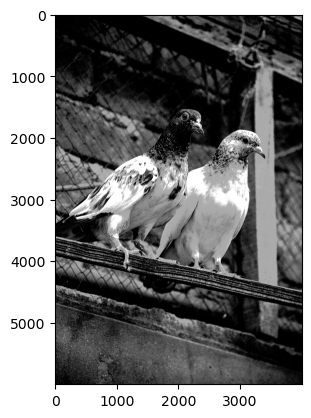

In [3]:
def quantized_image(image,   target_bits):
    L = 2 ** target_bits
    step_size = 256 // L
    quantized_indices = np.floor(image / step_size).astype(np.uint8)
    image_bit = quantized_indices * step_size
    image_bit = image_bit.astype(np.uint8)
    return image_bit
quantized_img = quantized_image(imgnew, 2)
plt.imshow(quantized_img, cmap='gray')

## Image translation

$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y 
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

Where:
- $(x, y)$ = original pixel coordinates  
- $(x', y')$ = transformed coordinates
- $t_x , t_y$ = translation parameters

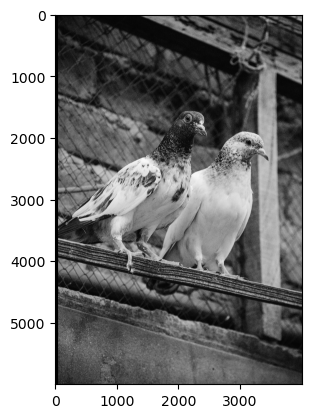

In [4]:
def translate_image(img, tx, ty):
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_img = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
    return translated_img
translated_img_function = translate_image(img, 50, 30)
plt.imshow(translated_img_function, cmap='gray')

## Image rotation with respect to the center of the image 

$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
=
\begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

Where:
- $(x, y)$ = original pixel coordinates  
- $(x', y')$ = transformed coordinates
- $\theta$ = rotation angle

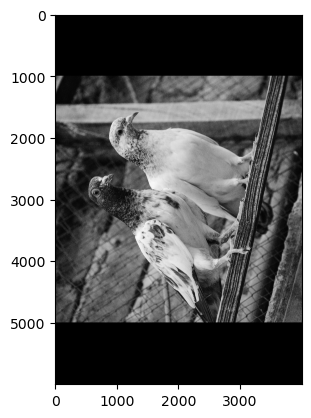

In [7]:
def rotate_image(img, angle):
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    return rotated_img
plt.imshow(rotate_image(img, 450), cmap='gray')

# Image Scaling 

**Scaling Transformation**: $\mathbf{I}_{scaled} = T(\mathbf{I}, s_x, s_y)$ where $T$ is the interpolation function

- **Input**: Image $\mathbf{I} \in \mathbb{R}^{h \times w \times c}$, Scale factors $s_x$, $s_y$
- **Output Dimensions**: $(h \cdot s_y, w \cdot s_x, c)$
- **Interpolation**: Uses bilinear interpolation for smooth scaling
- **Example**: $s_x = 1.5$, $s_y = 0.8$ → Width ×1.5, Height ×0.8

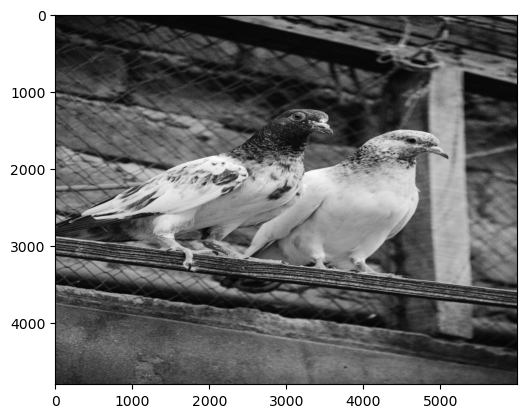

In [8]:
def scale_image(img, scale_x, scale_y):
    scaled_img = cv2.resize(img, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    return scaled_img
scaled_img_function = scale_image(img, 1.5, 0.8)
plt.imshow(scaled_img_function, cmap='gray')

# Image Shearing 


**Shearing Transformation**: $\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} 1 & s_x \\ s_y & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}$

- **Input**: Image $\mathbf{I}$, Shear factors $s_x$, $s_y$
- **Transformation Matrix**: $M = \begin{bmatrix} 1 & s_x & 0 \\ s_y & 1 & 0 \end{bmatrix}$
- **Coordinate Mapping**: $x' = x + s_x \cdot y$, $y' = y + s_y \cdot x$
- **Effect**: $s_x$ = horizontal shear, $s_y$ = vertical shear
- **Example**: $s_x = 0.3$, $s_y = 0.2$ → Moderate horizontal and vertical distortion

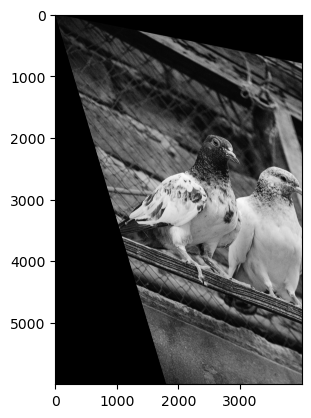

In [9]:
def shear_image(img, shear_x, shear_y):
    shear_matrix = np.float32([[1, shear_x, 0], [shear_y, 1, 0]])
    sheared_img = cv2.warpAffine(img, shear_matrix, (img.shape[1], img.shape[0]))
    return sheared_img
sheared_img = shear_image(img, 0.3, 0.2)
plt.imshow(sheared_img, cmap='gray')

# Affine Transformation 

**Affine Transformation**: $\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} b_1 \\ b_2 \end{bmatrix}$

- **Input**: Image $\mathbf{I}$, Source points $\mathbf{P}_1$, Target points $\mathbf{P}_2$
- **Transformation Matrix**: $M = \begin{bmatrix} a_{11} & a_{12} & b_1 \\ a_{21} & a_{22} & b_2 \end{bmatrix}$
- **Point Mapping**: Solves $M$ from $\mathbf{P}_2 = M \cdot \mathbf{P}_1$
- **Properties**: Preserves parallelism, lines, and ratios
- **Example**: 3 point pairs define the affine transformation

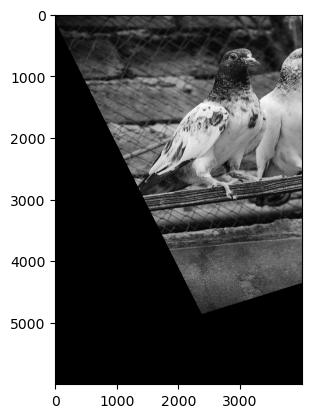

In [10]:
def affine_transform(img, pts1, pts2):
    height, width = img.shape[:2]
    affine_matrix = cv2.getAffineTransform(pts1, pts2)
    transformed_image = cv2.warpAffine(img, affine_matrix, (width, height))
    return transformed_image
pts1 = np.float32([[30, 30], [180, 30], [30, 180]])
pts2 = np.float32([[20, 80], [180, 30], [80, 200]])
plt.imshow(affine_transform(img, pts1, pts2), cmap='gray')

In [16]:
def STEGANOGRAPHY(img, secret_msg):
    binary_msg = ''.join(format(ord(char), '08b') for char in secret_msg)
    data_index = 0
    img_flat = img.flatten()
    for i in range(len(img_flat)):
        if data_index < len(binary_msg):
            img_flat[i] = (img_flat[i] & ~1) | int(binary_msg[data_index])
            data_index += 1
    stego_img = img_flat.reshape(img.shape)
    return stego_img
IMG1 = STEGANOGRAPHY(img, "QYGW91")
cv2.imshow("Steganography Image", IMG1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [17]:
def steganography_decode(stego_img):
    stego_flat = stego_img.flatten()
    extracted_bits = []
    for i, pixel in enumerate(stego_flat):
        bit = pixel & 1
        extracted_bits.append(str(bit))
        if (i + 1) % 8 == 0:
            last_8_bits = ''.join(extracted_bits[-8:])
            if last_8_bits == '00000000':  
                break
    if len(extracted_bits) % 8 == 0:
        extracted_bits = extracted_bits[:-8]
    extracted_message = ''
    for i in range(0, len(extracted_bits), 8):
        if i + 8 <= len(extracted_bits):
            byte_bits = ''.join(extracted_bits[i:i+8])
            char_code = int(byte_bits, 2)
            if 32 <= char_code <= 126:
                extracted_message += chr(char_code)
    
    return extracted_message

decoded_msg = steganography_decode(IMG1)
print("Decoded Message:", decoded_msg)

Decoded Message: QYGW91


### Contrast Stretching 

Given an image $f(x, y)$ with intensity values in the range $[r_{\min}, r_{\max}]$,  
the contrast stretching operation maps these values linearly to a new range $[t_{\min}, t_{\max}]$.

The transformation is defined as:

$$
g(x, y) = \frac{(f(x, y) - r_{\min}) \times (t_{\max} - t_{\min})}{r_{\max} - r_{\min}} + t_{\min}
$$

Where:

- $f(x, y)$ : original pixel intensity  
- $g(x, y)$ : transformed pixel intensity  
- $r_{\min} = \min(f(x, y))$ : minimum intensity in the input image  
- $r_{\max} = \max(f(x, y))$ : maximum intensity in the input image  
- $t_{\min}, t_{\max}$ : desired output range 

This transformation enhances contrast by stretching the dynamic range of intensity values.


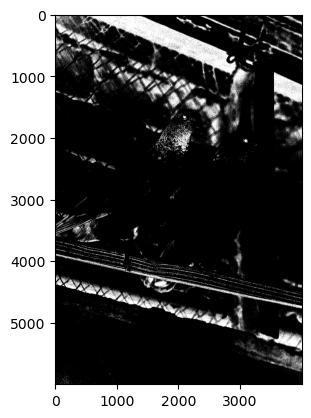

In [11]:
def contrast_stretching(img, t_min, t_max):
    r_min, r_max = np.min(img), np.max(img)
    stretched = ((img - r_min) * (t_max - t_min)) / (r_max - r_min) + t_min
    stretched = np.clip(stretched, t_min, t_max)
    return stretched.astype(np.uint8)
contrast_stretched = contrast_stretching(img, 0, 255)
plt.imshow(contrast_stretched, cmap='gray')


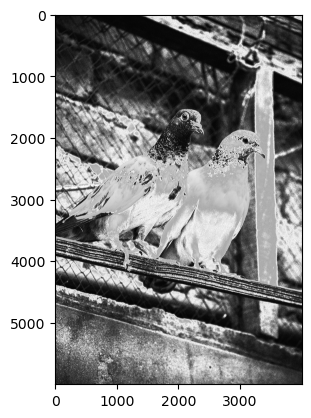

In [12]:
# Intensity level slicing (highlight specific range)
def intensity_slicing(img, low_thresh, high_thresh, highlight_value=255):
    result = img.copy()
    mask = (img >= low_thresh) & (img <= high_thresh)
    result[mask] = highlight_value
    return result

sliced_image = intensity_slicing(img, 100, 150)
plt.imshow(sliced_image, cmap='gray')

## Image Inversion Transformation

$$
g(x,y) = 255 - f(x,y)
$$

Where:
- $f(x,y)$ = original pixel intensity
- $g(x,y)$ = inverted pixel intensity

In [ ]:
img1 = np.zeros( (985,735) , np.uint8)
for i in range (985):
    for j in range (735):
        img1[i , j] = 255 - img[i , j]
cv2.imshow(" INVERTED IMAGE " , img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Logarithmic Transformation

$$
g(x,y) = c \cdot \log(1 + f (x,y))
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity  
- $c = \dfrac{255}{\log(1 + \max(f(x,y)))}$ scaling constant

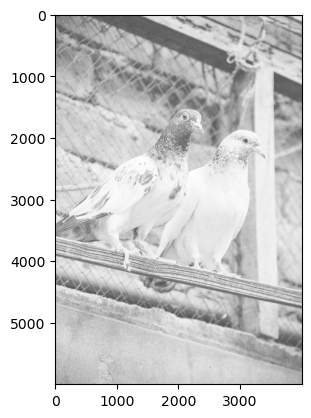

In [13]:
def log_transform ( img ):
    c = 255 / np.log(1 + np.max(img))
    log_image = c * (np.log ( img + 1))
    log_image = np.array ( log_image , dtype = np.uint8)
    return log_image
img1 = log_transform ( img )
plt.imshow(img1, cmap='gray')

## Exponential Transformation

$$
g(x,y) = c \cdot \left(e^{f(x,y)} - 1\right)
$$

Where:
- $f(x,y) = \dfrac{I(x,y)}{255}$ = normalized input intensity
- $g(x,y)$ = output pixel intensity
- $c = \dfrac{255}{e^{\max(f(x,y))} - 1}$ scaling constant

In [ ]:
def exponential_transform ( img ):
    c = 255 / ( np.exp ( np.max(img) / 255 ) - 1 )
    exp_image = c * ( np.exp ( img / 255 ) - 1 )
    exp_image = np.array ( exp_image , dtype = np.uint8)
    return exp_image
img1 = exponential_transform ( img )
cv2.imshow(" EXPONENTIAL TRANSFORMED IMAGE " , img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Power Law Transformation

$$
g(x,y) = c \cdot f(x,y)^{\gamma}
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity
- $\gamma$ = gamma parameter
- $c = \dfrac{255}{\max(f(x,y))^{\gamma}}$ scaling constant

In [22]:
def power_law_transform ( img , gamma ):
    c = 255 / (np.max(img) ** gamma)
    power_image = c * ( img ** gamma)
    power_image = np.array ( power_image , dtype = np.uint8)
    return power_image
imggamma = power_law_transform ( img1 , 1.5)
cv2.imshow(" POWER LAW TRANSFORMED IMAGE " , imggamma)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('gammaimage2.jpg', imggamma)

True

## Mean Filter 

For each pixel $I(x,y)$ with $n \times n$ kernel:

$$
I'(x,y) = \frac{1}{n^2} \sum_{i=-k}^{k} \sum_{j=-k}^{k} I(x+i, y+j)
$$

Where:
- $n$ = kernel size 
- $k = \frac{n-1}{2}$
- $I(x,y)$ = original pixel intensity
- $I'(x,y)$ = filtered pixel intensity

In [6]:
def mean_filter(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    return cv2.filter2D(img, -1, kernel)

mean_3x3 = mean_filter(img1, 3)
mean_5x5 = mean_filter(img1, 5)
mean_7x7 = mean_filter(img1, 7)


cv2.imshow('Mean 3x3', mean_3x3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('meanimage3.jpg' , mean_7x7)

True

## Gaussian Filter Operation

### 2D Gaussian Kernel
$$
G(x,y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{(x-\mu_x)^2 + (y-\mu_y)^2}{2\sigma^2}\right)
$$

### Discrete Kernel Generation
For $n \times n$ kernel with $\mu_x = \mu_y = \frac{n-1}{2}$:

$$
G[i,j] = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{(i-\frac{n-1}{2})^2 + (j-\frac{n-1}{2})^2}{2\sigma^2}\right)
$$

### Normalization
$$
K[i,j] = \frac{G[i,j]}{\sum_{i=0}^{n-1}\sum_{j=0}^{n-1} G[i,j]}
$$

Where:
- $\sigma$ = standard deviation (controls blur radius)
- $n$ = kernel size
- $(x,y)$ = spatial coordinates

In [16]:
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) *  np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)
def apply_gaussian_filter(img, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    return cv2.filter2D(img, -1, kernel)

gauss_kernel = gaussian_kernel(3, 3)
print(f"5x5 Gaussian kernel (sigma=1.0):\n{gauss_kernel}")
cv2.filter2D(img, -1, gauss_kernel)
gaussian_img = apply_gaussian_filter(img, 5, 3)
cv2.imshow('Gaussian 3x3', gaussian_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('gaussinaimage4.jpg' , gaussian_img)

5x5 Gaussian kernel (sigma=1.0):
[[0.1069973  0.11310982 0.1069973 ]
 [0.11310982 0.11957153 0.11310982]
 [0.1069973  0.11310982 0.1069973 ]]


True

# Laplacian Filter

## Laplacian Operator

### 4-Connected Laplacian
$$
\nabla^2 f(x,y) = f(x+1,y) + f(x-1,y) + f(x,y+1) + f(x,y-1) - 4f(x,y)
$$

### 8-Connected Laplacian  
$$
\nabla^2 f(x,y) = \sum_{i=-1}^{1}\sum_{j=-1}^{1} f(x+i,y+j) - 8f(x,y)
$$

## Kernel Representations

### 4-Connected Kernel
$$
K_4 = \begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

### 8-Connected Kernel
$$
K_8 = \begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

## Image Sharpening

$$
g(x,y) = f(x,y) + \alpha \cdot \nabla^2 f(x,y)
$$

Where:
- $f(x,y)$ = original image
- $\nabla^2 f(x,y)$ = Laplacian operator
- $\alpha$ = sharpening strength
- $g(x,y)$ = sharpened image

In [4]:

laplacian_kernel_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian_kernel_8 = np.array([[1, 1, 1],  [1, -8, 1],  [1, 1, 1]], dtype=np.float32)
laplacian_4 = cv2.filter2D(img.astype(np.float32), -1, laplacian_kernel_4)
laplacian_8 = cv2.filter2D(img.astype(np.float32), -1, laplacian_kernel_8)


def laplacian_sharpen(img, alpha):
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    sharpened = img.astype(np.float64) + alpha * laplacian
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    return sharpened

sharpened_4 = laplacian_sharpen(img, 5)
sharpened_8 = laplacian_sharpen(img, 0.5)

cv2.imshow('Laplacian 4-connected', laplacian_4)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Max Filter Operation

$$
g(x,y) = \max_{(i,j) \in W} f(x+i, y+j)
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity  
- $W$ = $n \times n$ neighborhood window
- $n$ = kernel size 

In [26]:
def max_filter(img, kernel_size):
    h, w = img.shape
    pad = kernel_size // 2
    output = np.zeros_like(img)
    padded = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            output[i, j] = np.max(region)
    
    return output

max_3x3 = max_filter(img , kernel_size=3)
max_5x5 = max_filter(img , kernel_size=5)
max_7x7 = max_filter(img , kernel_size=7)
cv2.imshow('Max Filter 3x3', max_3x3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('maximage3.jpg' , max_7x7)

True

## Min Filter Operation

$$
g(x,y) = \min_{(i,j) \in W} f(x+i, y+j)
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity  
- $W$ = $n \times n$ neighborhood window
- $n$ = kernel size 

In [31]:
def min_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded_img = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            neighborhood = padded_img[i:i+kernel_size, j:j+kernel_size]
            output[i, j] = np.min(neighborhood)
    
    return output

min_filtered = min_filter(img, 3)
min_3x3 = min_filter(img, kernel_size=3)
min_5x5 = min_filter(img , kernel_size=5)
min_7x7 = min_filter(img , kernel_size=7)
cv2.imshow('Min Filter 3x3', min_3x3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('minimage2.jpg' , min_5x5)

True

## Median Filter Operation

$$
g(x,y) = \text{median}\{f(x+i, y+j) \mid (i,j) \in W\}
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity  
- $W$ = $n \times n$ neighborhood window
- $n$ = kernel size 

In [39]:
def median_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded_img = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            neighborhood = padded_img[i:i+kernel_size, j:j+kernel_size]
            output[i, j] = np.median(neighborhood)
    
    return output

median_3 = median_filter(img, 7)
cv2.imwrite('medinaimage3.jpg', median_3)



True

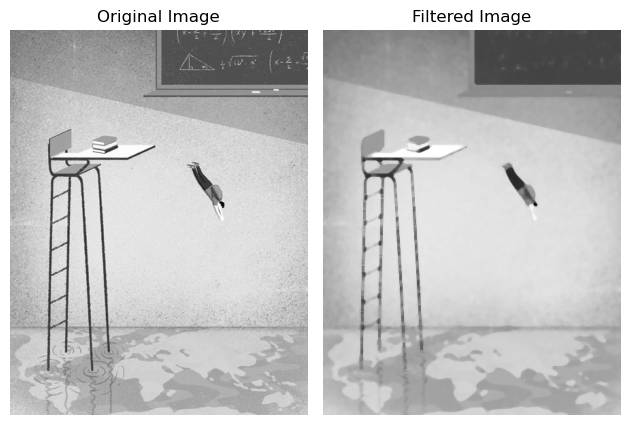

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(median_7, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Mean Shift Filter Operation

$$
g(x,y) = \frac{\sum_{(i,j) \in W} f(x+i,y+j) \cdot w(i,j)}{\sum_{(i,j) \in W} w(i,j)}
$$

$$
w(i,j) = \exp\left(-\frac{(f(x+i,y+j) - f(x,y))^2}{2\sigma^2}\right)
$$

Where:
- $f(x,y)$ = input pixel intensity
- $g(x,y)$ = output pixel intensity  
- $W$ = $n \times n$ neighborhood window
- $\sigma$ = bandwidth parameter
- $w(i,j)$ = Gaussian weight based on intensity difference

In [44]:
def mean_shift_filter(img, kernel_size, bandwidth):
    pad = kernel_size // 2
    padded_img = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img, dtype=float)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            center_value = img[i, j]
            neighborhood = padded_img[i:i+kernel_size, j:j+kernel_size]
            weights = np.exp(-((neighborhood - center_value) ** 2) / (2 * bandwidth ** 2))
            weighted_sum = np.sum(neighborhood * weights)
            weight_sum = np.sum(weights)
            output[i, j] = weighted_sum / weight_sum if weight_sum > 0 else center_value
    
    return output.astype(img.dtype)

mean_shift_filtered = mean_shift_filter(img1, 7, 15)
cv2.imwrite('meanshift3.jpg' , mean_shift_filtered)

True

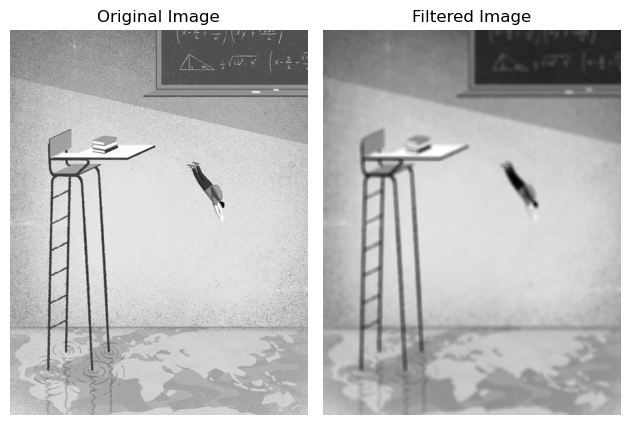

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_shift_filtered, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()